<a href="https://colab.research.google.com/github/DeepeshAgarawal/portfolio-utils/blob/main/NAV_computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authorizing Gdrive to access sheets

In [105]:
!pip install pandas-datareader
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
from datetime import date
from datetime import timedelta
import numpy as np 
gc = gspread.authorize(GoogleCredentials.get_application_default())

## Reading the tradebook provided by your broker

Reading a Google Sheet which contains all the buy/sell trasactions in your demat account (aka tradebook).

<p>Format of the tradebook:</p>

>Header|Description
>---|---
>Trade Date|Date of transaction
>Symbol|Symbol of the security traded as mentioned in Yahoo Finance
>Trade Type| buy or sell
>Qty|Quantity traded
>Price|Trade price

<p>Example entry:</p>

>Trade Date|Symbol|Trade Type|Qty|Price
>---|---|---|---|---
>2019-04-11|ASIANPAINT.NS|buy|5|1421


In [106]:
## Enter the URL of the Google Sheet
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1UMcytgb5_kkpnnnhf8RVbSzanispp-x44hiJTR94cGc/edit?usp=sharing')

sheet = wb.worksheet('Sheet1')
data_df = sheet.get_all_values()
df = pd.DataFrame(data_df)
df.columns = df.iloc[0]
df = df.iloc[1:]
df.head()
df['Trade Date'] = pd.to_datetime(df['Trade Date'])
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Qty'] = pd.to_numeric(df['Qty'], errors='coerce')
print(df.tail())
start_date = df['Trade Date'].iloc[0]
symbols = df['Symbol'].unique() 


0 Trade Date      Symbol Trade Type  Qty    Price
4 2019-07-31  ASIANPAINT       sell    1  1510.00
5 2019-07-31  ASIANPAINT       sell    2  1515.00
6 2019-08-09  ASIANPAINT       sell    2  1570.00
7 2019-08-13    RELIANCE        buy   14  1257.65
8 2019-09-16    AXISBANK        buy    2   667.40


In [107]:
symbols_start_date={}
for sym in symbols:
  symbols_start_date[sym] = df['Trade Date'][(df['Symbol'].values == sym).argmax()+1]

In [108]:
print(symbols_start_date)

{'ASIANPAINT': Timestamp('2019-04-11 00:00:00'), 'RCOM': Timestamp('2019-04-11 00:00:00'), 'RELIANCE': Timestamp('2019-08-13 00:00:00'), 'AXISBANK': Timestamp('2019-09-16 00:00:00')}


## Getting Data for the symbols present in the tradebook from Yahoo Finance.

In [109]:
#print(symbols)
panel_data = {}
for symbol in symbols:
  if symbol == "BCG":
    panel_data[symbol] = data.DataReader(symbol+".NS", 'yahoo', start_date, date.today() )['Close']
  else:
    panel_data[symbol] = data.DataReader(symbol+".NS", 'yahoo', symbols_start_date[symbol], date.today() )['Close']
#print(panel_data)

## Getting Benchmark data

In [110]:
def normalize(arr):
  norm_arr=[]
  for k in arr:
    norm_arr.append(k*100/arr[0])
  return norm_arr
 
indices  = {}
## Yahoo doesnt return historical closing prices of mid/small cap indices hence not using it for now, can replace it with other API calls
nifty = data.DataReader('^NSEI', 'yahoo', start_date, date.today())['Close']
#nifty_midcap150 = data.DataReader('BSEMID', 'quandl', start_date, date.today(), access_key="PfFeXvkrQaYu1dYs6Mdx")['Close']
indices['NIFTY 50'] = nifty
indices['NIFTY MIDCAP 100'] = data.DataReader('^CRSMID', 'yahoo', start_date, date.today())['Close']
indices['NIFTY MIDCAP 50'] = data.DataReader('^NSEMDCP50', 'yahoo', start_date, date.today())['Close']
indices['NIFTY 500'] = data.DataReader('^CRSLDX', 'yahoo', start_date, date.today())['Close']
 
nifty_arr             = np.array(normalize(nifty))

# print(indices)
indices_arr = {}
for temp in indices:
  indices_arr[temp] = np.array(normalize(indices[temp]))


## Function to return trades upto a certain date

In [111]:
def get_holdings(holdings_date):
  return df[df['Trade Date']<=holdings_date]

## Function to factor in stock splits

If on the day of trasaction the 'Price' entry is > 2 times the closing price of that day it is considered as a stock split.

In [112]:
for index, row in df.iterrows():
    #to account for stock splits
    split = 1
    if (float(row['Price'])/float(panel_data[row['Symbol']][row['Trade Date']])) > 1.9:
      print("Found Split")
      print("Before split \n", df.loc[index])
      split = round(float(row['Price'])/float(panel_data[row['Symbol']][row['Trade Date']]))
      df.loc[index,('Qty')] = float(row['Qty'])*split
      df.loc[index,('Price')] = float(row['Price'])/split      
      print("\nAfter split \n", df.loc[index])


## Calculates the NAV, AUM and number of outstanding units of our mutual fund 

In [113]:

aum = 0
nav = 100
units = 0
ctr=0
cash=0
nav_arr = []
start_date = df['Trade Date'].iloc[0]
 
for i in nifty.keys():
  # if i == date(2021,1,14):
  #   raise Exception('I know Python!')

  # if len(nav_arr) > 81 :
  #   break
  # print(len(nav_arr),i,cash,nav,units,aum)
  aum=0
  holding_current_df = get_holdings(i)   
  #print(holding_current_df)

  # intraday handling 
  intraday_sum = {}
  for sym in symbols:
    intraday_sum[sym] = 0;

  for index, row in holding_current_df.iterrows(): 
    if index > ctr:
      if row['Trade Type'] == 'buy':     
        intraday_sum[row['Symbol']] +=  row['Qty'] 
      else:
        intraday_sum[row['Symbol']] -=  row['Qty']  

  for index, row in holding_current_df.iterrows():    
    if row['Trade Type'] == 'buy':
      if index > ctr:
        buy_val = float(row['Price'])*float(row['Qty'])*float(1.0)
        if intraday_sum[row['Symbol']] !=0:
          if buy_val >= cash:           
            units += (buy_val-cash)/nav        
            cash = 0              
          else:
            cash = cash - buy_val
      aum += float(panel_data[row['Symbol']][i])*float(row['Qty'])*float(1.0)
    else:
      if intraday_sum[row['Symbol']] !=0:
        if index > ctr:
          cash += float(row['Price'])*float(row['Qty']) # A sell order doesnt reduce the number of units however this cash is utilized in the next buy order to balance out the number of outstanding units
      aum += float(panel_data[row['Symbol']][i])*float(row['Qty'])*float(-1.0) 
  # print(len(nav_arr),i,cash,nav,units,aum)
  aum += cash
  ctr=holding_current_df.shape[0]
  nav = aum/units
  # units -= cash/nav
  # aum -=cash  
  # cash=0  
  nav_arr.append(nav)
  # print(len(nav_arr),i,cash,nav,units,aum)
  #print(i)
  #print(holding_current_df)

## Plotting the relative return graphs for the past X days 

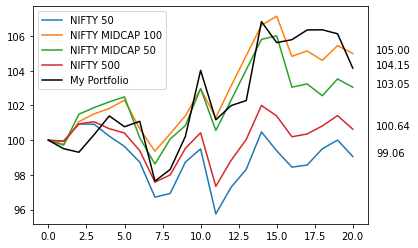

In [114]:
import matplotlib.pyplot as plt
def get_past_x_days_normalized_data(arr, days):
  if len(arr) < days:
     raise Exception("Please enter past days between 2 and", len(arr))    
  temp = [arr[j] for j in range(len(arr)-days,len(arr))]
  temp_arr = np.array(normalize(temp))
  return temp_arr
 
def plot_past_x_days(past_days=len(nav_arr)):
  if isinstance(past_days, str) and past_days.lower() == 'ytd':
    past_days = (date.today() - date(date.today().year, 1, 1)).days
 
  past_days = len(nifty[date.today()-timedelta(days=past_days):date.today()])  
  temp_nav_arr = get_past_x_days_normalized_data(nav_arr,past_days)
  temp_ind_arr = {}
  for ind_arr in indices_arr:
    temp_ind_arr[ind_arr] = get_past_x_days_normalized_data(indices_arr[ind_arr],past_days)  
    plt.plot(temp_ind_arr[ind_arr],label=ind_arr)

  #temp_nifty_smallcap250_arr = get_past_x_days_normalized_data(nifty_smallcap250_arr,past_days)
  plt.plot(temp_nav_arr,'black',label='My Portfolio')

  #plt.plot(temp_nifty_smallcap250_arr,'y',label='NIFTY Smallcap 250')
  plt.legend()
  plt.annotate('%0.2f' % temp_nav_arr[-1], xy=(1, temp_nav_arr[-1]), xytext=(8, 0), 
                  xycoords=('axes fraction', 'data'), textcoords='offset points')
  for var in temp_ind_arr:      
      plt.annotate('%0.2f' % temp_ind_arr[var][-1], xy=(1, temp_ind_arr[var][-1]), xytext=(8, 0), 
                  xycoords=('axes fraction', 'data'), textcoords='offset points')
  plt.show()
 
plot_past_x_days(30)